##### Copyright 2021 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# MoViNet for streaming action recognition

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/movinet"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/movinet.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/hub/tutorials/movinet.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/hub/tutorials/movinet.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/movinet/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

This tutorial demonstrates how to use a pretrained video classification model to classify an activity (such as dancing, swimming, biking etc) in the given video.   

The model architecture used in this tutorial is called [MoViNet](https://arxiv.org/pdf/2103.11511.pdf) (Mobile Video Networks). MoVieNets are a family of efficient video classification models trained on huge dataset ([Kinetics 600](https://deepmind.com/research/open-source/kinetics)).

In contrast to the [i3d models](https://tfhub.dev/s?q=i3d-kinetics) available on TF Hub, MoViNets also support frame-by-frame inference on streaming video.

The pretrained models are available from [TF Hub](https://tfhub.dev/google/collections/movinet/1). The TF Hub collection also includes quantized models optimized for [TFLite](https://tensorflow.org/lite).

The source for these models is available in the [TensorFlow Model Garden](https://github.com/tensorflow/models/tree/master/official/projects/movinet). This includes a [longer version of this tutorial](https://colab.sandbox.google.com/github/tensorflow/models/blob/master/official/projects/movinet/movinet_tutorial.ipynb) that also covers building and fine-tuning a MoViNet model.

This MoViNet tutorial is part of a series of TensorFlow video tutorials. Here are the other three tutorials:

- [Load video data](https://www.tensorflow.org/tutorials/load_data/video): This tutorial explains how to load and preprocess video data into a TensorFlow dataset pipeline from scratch.
- [Build a 3D CNN model for video classification](https://www.tensorflow.org/tutorials/video/video_classification). Note that this tutorial uses a (2+1)D CNN that decomposes the spatial and temporal aspects of 3D data; if you are using volumetric data such as an MRI scan, consider using a 3D CNN instead of a (2+1)D CNN.
- [Transfer learning for video classification with MoViNet](https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet): This tutorial explains how to use a pre-trained video classification model trained on a different dataset with the UCF-101 dataset.


![jumping jacks plot](https://storage.googleapis.com/tf_model_garden/vision/movinet/artifacts/jumpingjacks_plot.gif)

## Setup

For inference on smaller models (A0-A2), CPU is sufficient for this Colab.

In [2]:
# !sudo apt install -y ffmpeg
!pip install -q mediapy

In [3]:
!pip uninstall -q -y opencv-python-headless
!pip install -q "opencv-python-headless<4.3"

In [4]:
# Import libraries
import pathlib

import matplotlib as mpl
import matplotlib.pyplot as plt
import mediapy as media
import numpy as np
import PIL

import tensorflow as tf
import tensorflow_hub as hub
import tqdm

mpl.rcParams.update({
    'font.size': 10,
})

2024-09-02 15:56:22.514720: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-02 15:56:22.524126: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-02 15:56:22.534683: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-02 15:56:22.537899: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-02 15:56:22.545751: I tensorflow/core/platform/cpu_feature_guar

Get the kinetics 600 label list, and print the first few labels:

In [5]:
labels_path = tf.keras.utils.get_file(
    fname='labels.txt',
    origin='https://raw.githubusercontent.com/tensorflow/models/f8af2291cced43fc9f1d9b41ddbf772ae7b0d7d2/official/projects/movinet/files/kinetics_600_labels.txt'
)
labels_path = pathlib.Path(labels_path)

lines = labels_path.read_text().splitlines()
KINETICS_600_LABELS = np.array([line.strip() for line in lines])
KINETICS_600_LABELS[:20]

array(['abseiling', 'acting in play', 'adjusting glasses', 'air drumming',
       'alligator wrestling', 'answering questions', 'applauding',
       'applying cream', 'archaeological excavation', 'archery',
       'arguing', 'arm wrestling', 'arranging flowers',
       'assembling bicycle', 'assembling computer',
       'attending conference', 'auctioning', 'backflip (human)',
       'baking cookies', 'bandaging'], dtype='<U49')

To provide a simple example video for classification, we can load a short gif of jumping jacks being performed.

![jumping jacks](https://github.com/tensorflow/models/raw/f8af2291cced43fc9f1d9b41ddbf772ae7b0d7d2/official/projects/movinet/files/jumpingjack.gif)

Attribution: Footage shared by [Coach Bobby Bluford](https://www.youtube.com/watch?v=-AxHpj-EuPg) on YouTube under the CC-BY license.

Download the gif.

In [6]:
KINETICS_600_LABELS

array(['abseiling', 'acting in play', 'adjusting glasses', 'air drumming',
       'alligator wrestling', 'answering questions', 'applauding',
       'applying cream', 'archaeological excavation', 'archery',
       'arguing', 'arm wrestling', 'arranging flowers',
       'assembling bicycle', 'assembling computer',
       'attending conference', 'auctioning', 'backflip (human)',
       'baking cookies', 'bandaging', 'barbequing', 'bartending',
       'base jumping', 'bathing dog', 'battle rope training',
       'beatboxing', 'bee keeping', 'belly dancing', 'bench pressing',
       'bending back', 'bending metal', 'biking through snow',
       'blasting sand', 'blowdrying hair', 'blowing bubble gum',
       'blowing glass', 'blowing leaves', 'blowing nose',
       'blowing out candles', 'bobsledding', 'bodysurfing', 'bookbinding',
       'bottling', 'bouncing on bouncy castle', 'bouncing on trampoline',
       'bowling', 'braiding hair', 'breading or breadcrumbing',
       'breakdancing',

In [7]:
jumpingjack_url = 'https://github.com/tensorflow/models/raw/f8af2291cced43fc9f1d9b41ddbf772ae7b0d7d2/official/projects/movinet/files/jumpingjack.gif'
jumpingjack_path = tf.keras.utils.get_file(
    fname='jumpingjack.gif',
    origin=jumpingjack_url,
    cache_dir='.', cache_subdir='.',
)

Define a function to read a gif file into a `tf.Tensor`:

In [8]:
#@title
# Read and process a video
def load_gif(file_path, image_size=(224, 224)):
  """Loads a gif file into a TF tensor.

  Use images resized to match what's expected by your model.
  The model pages say the "A2" models expect 224 x 224 images at 5 fps

  Args:
    file_path: path to the location of a gif file.
    image_size: a tuple of target size.

  Returns:
    a video of the gif file
  """
  # Load a gif file, convert it to a TF tensor
  raw = tf.io.read_file(file_path)
  video = tf.io.decode_gif(raw)
  # Resize the video
  video = tf.image.resize(video, image_size)
  # change dtype to a float32
  # Hub models always want images normalized to [0,1]
  # ref: https://www.tensorflow.org/hub/common_signatures/images#input
  video = tf.cast(video, tf.float32) / 255.
  return video

The video's shape is `(frames, height, width, colors)`

In [9]:
jumpingjack=load_gif(jumpingjack_path)
jumpingjack.shape

I0000 00:00:1725272783.973655   45824 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-02 15:56:24.011573: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


TensorShape([13, 224, 224, 3])

## How to use the model

This section contains a walkthrough showing how to use the [models from TensorFlow Hub](https://tfhub.dev/google/collections/movinet/1). If you just want to see the models in action, skip to the next section.

There are two versions of each model: `base` and `streaming`.

* The `base` version takes a video as input, and returns the probabilities averaged over the frames.
* The `streaming` version takes a video frame and an RNN state as input, and returns the predictions for that frame, and the new RNN state.

### The base model

Download the [pretrained model from TensorFlow Hub](https://tfhub.dev/tensorflow/movinet/a2/base/kinetics-600/classification/3).

In [10]:
%%time
id = 'a2'
mode = 'base'
version = '3'
hub_url = f'https://tfhub.dev/tensorflow/movinet/{id}/{mode}/kinetics-600/classification/{version}'
model = hub.load(hub_url)

CPU times: user 6.48 s, sys: 246 ms, total: 6.72 s
Wall time: 6.72 s


This version of the model has one `signature`. It takes an `image` argument which is a `tf.float32` with shape `(batch, frames, height, width, colors)`. It returns a dictionary containing one output: A `tf.float32` tensor of logits with shape `(batch, classes)`.

In [11]:
sig = model.signatures['serving_default']
print(sig.pretty_printed_signature())

Input Parameters:
  image (KEYWORD_ONLY): TensorSpec(shape=(None, None, None, None, 3), dtype=tf.float32, name='image')
Output Type:
  Dict[['classifier_head', TensorSpec(shape=(None, 600), dtype=tf.float32, name='classifier_head')]]
Captures:
  124109840280816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124109840341072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124109840340896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124109840340544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124109840340720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124109840280464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124109840340368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124109840339840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124109840340016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124109840340192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124109840280640: TensorSpec(shape=(), dtype=tf.resourc

To run this signature on the video you need to add the outer `batch` dimension to the video first.

In [12]:
#warmup
sig(image = jumpingjack[tf.newaxis, :1]);

I0000 00:00:1725272791.440456   45894 service.cc:146] XLA service 0x70e024022810 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725272791.440478   45894 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1725272791.446404   45894 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [13]:
%%time
logits = sig(image = jumpingjack[tf.newaxis, ...])
logits = logits['classifier_head'][0]

print(logits.shape)
print()

(600,)

CPU times: user 11.6 s, sys: 170 ms, total: 11.8 s
Wall time: 5.96 s


Define a `get_top_k` function that packages the above output processing for later.

In [14]:
#@title
# Get top_k labels and probabilities
def get_top_k(probs, k=5, label_map=KINETICS_600_LABELS):
  """Outputs the top k model labels and probabilities on the given video.

  Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    k: the number of top predictions to select.
    label_map: a list of labels to map logit indices to label strings.

  Returns:
    a tuple of the top-k labels and probabilities.
  """
  # Sort predictions to find top_k
  top_predictions = tf.argsort(probs, axis=-1, direction='DESCENDING')[:k]
  # collect the labels of top_k predictions
  top_labels = tf.gather(label_map, top_predictions, axis=-1)
  # decode lablels
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]
  # top_k probabilities of the predictions
  top_probs = tf.gather(probs, top_predictions, axis=-1).numpy()
  return tuple(zip(top_labels, top_probs))

Convert the `logits` to probabilities, and look up the top 5 classes for the video. The model confirms that the video is probably of `jumping jacks`.

In [15]:
probs = tf.nn.softmax(logits, axis=-1)
for label, p in get_top_k(probs):
  print(f'{label:20s}: {p:.3f}')

jumping jacks       : 0.834
zumba               : 0.008
lunge               : 0.003
doing aerobics      : 0.003
polishing metal     : 0.002


### The streaming model

The previous section used a model that runs over a whole video. Often when processing a video you don't want a single prediction at the end, you want to update predictions frame by frame. The `stream` versions of the model allow you to do this.

Load the `stream` version of the model.

In [16]:
%%time
id = 'a2'
mode = 'stream'
version = '3'
hub_url = f'https://tfhub.dev/tensorflow/movinet/{id}/{mode}/kinetics-600/classification/{version}'
model = hub.load(hub_url)

CPU times: user 16.7 s, sys: 736 ms, total: 17.4 s
Wall time: 17.4 s


Using this model is slightly more complex than the `base` model. You have to keep track of the internal state of the model's RNNs.

In [17]:
list(model.signatures.keys())

['call', 'init_states']

The `init_states` signature takes the video's **shape** `(batch, frames, height, width, colors)` as input, and returns a large dictionary of tensors containing the initial RNN states:

In [18]:
lines = model.signatures['init_states'].pretty_printed_signature().splitlines()
lines = lines[:10]
lines.append('      ...')
print('.\n'.join(lines))

Input Parameters:.
  input_shape (KEYWORD_ONLY): TensorSpec(shape=(5,), dtype=tf.int32, name='input_shape').
Output Type:.
  Dict[['state/b4/l2/pool_buffer', TensorSpec(shape=(None, 1, 1, 1, 384), dtype=tf.float32, name='state/b4/l2/pool_buffer')], ['state/b1/l2/pool_buffer', TensorSpec(shape=(None, 1, 1, 1, 96), dtype=tf.float32, name='state/b1/l2/pool_buffer')], ['state/b1/l1/pool_frame_count', TensorSpec(shape=(1,), dtype=tf.int32, name='state/b1/l1/pool_frame_count')], ['state/b1/l0/pool_frame_count', TensorSpec(shape=(1,), dtype=tf.int32, name='state/b1/l0/pool_frame_count')], ['state/b2/l2/pool_buffer', TensorSpec(shape=(None, 1, 1, 1, 240), dtype=tf.float32, name='state/b2/l2/pool_buffer')], ['state/b4/l0/pool_frame_count', TensorSpec(shape=(1,), dtype=tf.int32, name='state/b4/l0/pool_frame_count')], ['state/b3/l1/pool_frame_count', TensorSpec(shape=(1,), dtype=tf.int32, name='state/b3/l1/pool_frame_count')], ['state/b3/l4/pool_buffer', TensorSpec(shape=(None, 1, 1, 1, 144), dty

In [19]:
initial_state = model.init_states(jumpingjack[tf.newaxis, ...].shape)

In [20]:
type(initial_state)

dict

In [21]:
list(sorted(initial_state.keys()))[:5]

['state/b0/l0/pool_buffer',
 'state/b0/l0/pool_frame_count',
 'state/b0/l1/pool_buffer',
 'state/b0/l1/pool_frame_count',
 'state/b0/l1/stream_buffer']

Once you have the initial state for the RNNs, you can pass the state and a video frame as input (keeping the `(batch, frames, height, width, colors)` shape for the video frame). The model returns a `(logits, state)` pair.

After just seeing the first frame, the model is not convinced that the video is of "jumping jacks":

In [22]:
inputs = initial_state.copy()

# Add the batch axis, take the first frme, but keep the frame-axis.
inputs['image'] = jumpingjack[tf.newaxis, 0:1, ...]

In [23]:
# warmup
model(inputs);

In [24]:
logits, new_state = model(inputs)
logits = logits[0]
probs = tf.nn.softmax(logits, axis=-1)

for label, p in get_top_k(probs):
  print(f'{label:20s}: {p:.3f}')

print()

golf chipping       : 0.427
tackling            : 0.134
lunge               : 0.056
stretching arm      : 0.053
passing american football (not in game): 0.039



If you run the model in a loop, passing the updated state with each frame, the model quickly converges to the correct result:

In [25]:
%%time
state = initial_state.copy()
all_logits = []

for n in range(len(jumpingjack)):
  inputs = state
  inputs['image'] = jumpingjack[tf.newaxis, n:n+1, ...]
  result, state = model(inputs)
  all_logits.append(logits)

probabilities = tf.nn.softmax(all_logits, axis=-1)

CPU times: user 998 ms, sys: 154 ms, total: 1.15 s
Wall time: 414 ms


In [26]:
for label, p in get_top_k(probabilities[-1]):
  print(f'{label:20s}: {p:.3f}')

golf chipping       : 0.427
tackling            : 0.134
lunge               : 0.056
stretching arm      : 0.053
passing american football (not in game): 0.039


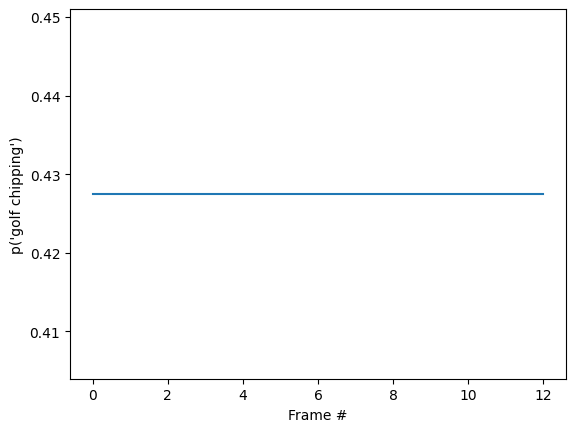

In [27]:
id = tf.argmax(probabilities[-1])
plt.plot(probabilities[:, id])
plt.xlabel('Frame #')
plt.ylabel(f"p('{KINETICS_600_LABELS[id]}')");

You may notice that the final probability is much more certain than in the previous section where you ran the `base` model. The `base` model returns an average of the predictions over the frames.

In [28]:
for label, p in get_top_k(tf.reduce_mean(probabilities, axis=0)):
  print(f'{label:20s}: {p:.3f}')

golf chipping       : 0.427
tackling            : 0.134
lunge               : 0.056
stretching arm      : 0.053
passing american football (not in game): 0.039


## Animate the predictions over time

The previous section went into some details about how to use these models. This section builds on top of that to produce some nice inference animations.

The hidden cell below to defines helper functions used in this section.

In [29]:
#@title
# Get top_k labels and probabilities predicted using MoViNets streaming model
def get_top_k_streaming_labels(probs, k=5, label_map=KINETICS_600_LABELS):
  """Returns the top-k labels over an entire video sequence.

  Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    k: the number of top predictions to select.
    label_map: a list of labels to map logit indices to label strings.

  Returns:
    a tuple of the top-k probabilities, labels, and logit indices
  """
  top_categories_last = tf.argsort(probs, -1, 'DESCENDING')[-1, :1]
  # Sort predictions to find top_k
  categories = tf.argsort(probs, -1, 'DESCENDING')[:, :k]
  categories = tf.reshape(categories, [-1])

  counts = sorted([
      (i.numpy(), tf.reduce_sum(tf.cast(categories == i, tf.int32)).numpy())
      for i in tf.unique(categories)[0]
  ], key=lambda x: x[1], reverse=True)

  top_probs_idx = tf.constant([i for i, _ in counts[:k]])
  top_probs_idx = tf.concat([top_categories_last, top_probs_idx], 0)
  # find unique indices of categories
  top_probs_idx = tf.unique(top_probs_idx)[0][:k+1]
  # top_k probabilities of the predictions
  top_probs = tf.gather(probs, top_probs_idx, axis=-1)
  top_probs = tf.transpose(top_probs, perm=(1, 0))
  # collect the labels of top_k predictions
  top_labels = tf.gather(label_map, top_probs_idx, axis=0)
  # decode the top_k labels
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]

  return top_probs, top_labels, top_probs_idx

# Plot top_k predictions at a given time step
def plot_streaming_top_preds_at_step(
    top_probs,
    top_labels,
    step=None,
    image=None,
    legend_loc='lower left',
    duration_seconds=10,
    figure_height=500,
    playhead_scale=0.8,
    grid_alpha=0.3):
  """Generates a plot of the top video model predictions at a given time step.

  Args:
    top_probs: a tensor of shape (k, num_frames) representing the top-k
      probabilities over all frames.
    top_labels: a list of length k that represents the top-k label strings.
    step: the current time step in the range [0, num_frames].
    image: the image frame to display at the current time step.
    legend_loc: the placement location of the legend.
    duration_seconds: the total duration of the video.
    figure_height: the output figure height.
    playhead_scale: scale value for the playhead.
    grid_alpha: alpha value for the gridlines.

  Returns:
    A tuple of the output numpy image, figure, and axes.
  """
  # find number of top_k labels and frames in the video
  num_labels, num_frames = top_probs.shape
  if step is None:
    step = num_frames
  # Visualize frames and top_k probabilities of streaming video
  fig = plt.figure(figsize=(6.5, 7), dpi=300)
  gs = mpl.gridspec.GridSpec(8, 1)
  ax2 = plt.subplot(gs[:-3, :])
  ax = plt.subplot(gs[-3:, :])
  # display the frame
  if image is not None:
    ax2.imshow(image, interpolation='nearest')
    ax2.axis('off')
  # x-axis (frame number)
  preview_line_x = tf.linspace(0., duration_seconds, num_frames)
  # y-axis (top_k probabilities)
  preview_line_y = top_probs

  line_x = preview_line_x[:step+1]
  line_y = preview_line_y[:, :step+1]

  for i in range(num_labels):
    ax.plot(preview_line_x, preview_line_y[i], label=None, linewidth='1.5',
            linestyle=':', color='gray')
    ax.plot(line_x, line_y[i], label=top_labels[i], linewidth='2.0')


  ax.grid(which='major', linestyle=':', linewidth='1.0', alpha=grid_alpha)
  ax.grid(which='minor', linestyle=':', linewidth='0.5', alpha=grid_alpha)

  min_height = tf.reduce_min(top_probs) * playhead_scale
  max_height = tf.reduce_max(top_probs)
  ax.vlines(preview_line_x[step], min_height, max_height, colors='red')
  ax.scatter(preview_line_x[step], max_height, color='red')

  ax.legend(loc=legend_loc)

  plt.xlim(0, duration_seconds)
  plt.ylabel('Probability')
  plt.xlabel('Time (s)')
  plt.yscale('log')

  fig.tight_layout()
  fig.canvas.draw()

  data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  plt.close()

  figure_width = int(figure_height * data.shape[1] / data.shape[0])
  image = PIL.Image.fromarray(data).resize([figure_width, figure_height])
  image = np.array(image)

  return image

# Plotting top_k predictions from MoViNets streaming model
def plot_streaming_top_preds(
    probs,
    video,
    top_k=5,
    video_fps=25.,
    figure_height=500,
    use_progbar=True):
  """Generates a video plot of the top video model predictions.

  Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    video: the video to display in the plot.
    top_k: the number of top predictions to select.
    video_fps: the input video fps.
    figure_fps: the output video fps.
    figure_height: the height of the output video.
    use_progbar: display a progress bar.

  Returns:
    A numpy array representing the output video.
  """
  # select number of frames per second
  video_fps = 8.
  # select height of the image
  figure_height = 500
  # number of time steps of the given video
  steps = video.shape[0]
  # estimate duration of the video (in seconds)
  duration = steps / video_fps
  # estimate top_k probabilities and corresponding labels
  top_probs, top_labels, _ = get_top_k_streaming_labels(probs, k=top_k)

  images = []
  step_generator = tqdm.trange(steps) if use_progbar else range(steps)
  for i in step_generator:
    image = plot_streaming_top_preds_at_step(
        top_probs=top_probs,
        top_labels=top_labels,
        step=i,
        image=video[i],
        duration_seconds=duration,
        figure_height=figure_height,
    )
    images.append(image)

  return np.array(images)

Start by running the streaming model across the frames of the video, and collecting the logits:

In [30]:
init_states = model.init_states(jumpingjack[tf.newaxis].shape)

In [31]:
# Insert your video clip here
video = jumpingjack
images = tf.split(video[tf.newaxis], video.shape[0], axis=1)

all_logits = []

# To run on a video, pass in one frame at a time
states = init_states
for image in tqdm.tqdm(images):
  # predictions for each frame
  logits, states = model({**states, 'image': image})
  all_logits.append(logits)

# concatenating all the logits
logits = tf.concat(all_logits, 0)
# estimating probabilities
probs = tf.nn.softmax(logits, axis=-1)

100%|██████████| 13/13 [00:00<00:00, 33.91it/s]


In [32]:
final_probs = probs[-1]
print('Top_k predictions and their probablities\n')
for label, p in get_top_k(final_probs):
  print(f'{label:20s}: {p:.3f}')

Top_k predictions and their probablities

jumping jacks       : 0.999
zumba               : 0.000
doing aerobics      : 0.000
dancing charleston  : 0.000
slacklining         : 0.000


Convert the sequence of probabilities into a video:

In [33]:
# Generate a plot and output to a video tensor
plot_video = plot_streaming_top_preds(probs, video, video_fps=8.)

  0%|          | 0/13 [00:00<?, ?it/s]/tmp/ipykernel_45824/567636217.py:112: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
100%|██████████| 13/13 [00:03<00:00,  4.04it/s]


In [34]:
# For gif format, set codec='gif'
media.show_video(plot_video, fps=3)

## Resources

The pretrained models are available from [TF Hub](https://tfhub.dev/google/collections/movinet/1). The TF Hub collection also includes quantized models optimized for [TFLite](https://tensorflow.org/lite).

The source for these models is available in the [TensorFlow Model Garden](https://github.com/tensorflow/models/tree/master/official/projects/movinet). This includes a [longer version of this tutorial](https://colab.sandbox.google.com/github/tensorflow/models/blob/master/official/projects/movinet/movinet_tutorial.ipynb) that also covers building and fine-tuning a MoViNet model.

## Next Steps

To learn more about working with video data in TensorFlow, check out the following tutorials:

* [Load video data](https://www.tensorflow.org/tutorials/load_data/video)
* [Build a 3D CNN model for video classification](https://www.tensorflow.org/tutorials/video/video_classification)
* [Transfer learning for video classification with MoViNet](https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet)

Milestone Definition
Stakeholder Alignment
Define Objectives
Data Integrity and Validation Testing
Error Handling
Validation Testing
Data Integrity Checks
Functional Testing
User Acceptance Testing (UAT)
End-to-End Testing
Component Testing
Integration Testing
Security Testing
API Integration
System Integration
API Development
API Testing
API Documentation
FastAPI Creation
Report Generation
Report Automation
Monthly Summarized Reports
Daily Email Reports
Data Management
Data Access Control
Data Retention Policy
Data Storage Management
Load Management
Scalability Planning
Load Optimization
Server Load Assessment
Project Documentation
